# Height data

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from cosmos.models import Tracker
from cosmos.distributions import AffineBeta, FixedOffsetGamma
from cosmos.models.utils import pi_m_calc, pi_theta_calc, theta_trans_calc
from cosmos.utils.glimpse_reader import read_glimpse, CoSMoSDataset

In [3]:
import pyro.poutine as poutine
from pyro.infer import infer_discrete
from pyro.ops.indexing import Vindex
from scipy.io import savemat
#plt.rc('text', usetex=True)

In [4]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve

from scipy.io import loadmat

In [5]:
class GaussianSpot():
    def __init__(self, target, drift, X, Y):
        # create meshgrid of DxD pixel positions
        i_pixel, j_pixel = torch.meshgrid(
            torch.arange(X), torch.arange(Y))
        self.ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1).float()

        # drift locs for 2D gaussian spot
        self.target_locs = torch.tensor(
            drift[["dx", "dy"]].values.reshape(-1, 2)
            + target[["x", "y"]].values.reshape(-1, 1, 2)) \
            .float()

    # Ideal 2D gaussian spots
    def forward(self, height, width, x, y, n_idx, m_mask=None, f=None):
        if m_mask is not None:
            height = height.masked_fill(~m_mask, 0.)
        if f is not None:
            spot_locs = self.target_locs[n_idx, f] + torch.stack((x, y), dim=-1)
        else:
            spot_locs = self.target_locs[n_idx] + torch.stack((x, y), dim=-1)
        rv = dist.MultivariateNormal(
            spot_locs[..., None, None, :],
            scale_tril=torch.eye(2) * width[..., None, None, None, None])
        gaussian_spot = torch.exp(rv.log_prob(self.ij_pixel))  # N,F,D,D
        return (height[..., None, None] * gaussian_spot).sum(dim=(0,1))

### Time Independent FOV

In [6]:
N = 15 # number of AOIs
D = 14 # AOI size
F = 500 # number of frames

In [7]:
# target locations
X, Y = np.meshgrid(np.arange(5)*D*2+2*D+(D-1)/2, np.arange(3)*D*2+2*D+(D-1)/2)

target = pd.DataFrame(data={"x": X.flatten(), "y": Y.flatten()}, index=np.arange(N))
target.index.name = "aoi"

drift = pd.DataFrame(data={"dx": 0., "dy": 0.}, index=np.arange(F))
drift.index.name = "frame"

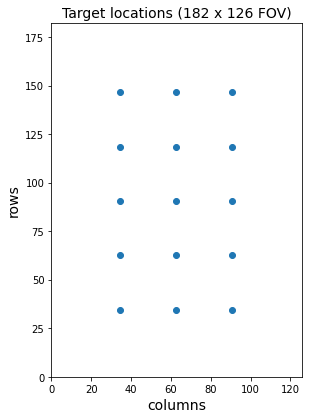

In [8]:
plt.figure(figsize=(9/2,13/2))
plt.scatter(Y, X)
plt.xlim(0, 28*5-14)
plt.ylim(0, 28*7-14)
plt.ylabel("rows", fontsize=14)
plt.xlabel("columns", fontsize=14)
plt.title("Target locations (182 x 126 FOV)", fontsize=14)
plt.show()

In [9]:
loc = GaussianSpot(target, drift, 2*D*7-14, 2*D*5-14)

In [10]:
sim = "height"
heights = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]
#heights = ["0300", "0500"]
pi_z = "15"
lamda_j = "15"
sigma = "0.2"

In [33]:
((D+1) / (2*float(2))) ** 2 - 1

13.0625

In [29]:
(D+1) / (2 * np.sqrt(100 + 1))

0.7462778926574919

In [11]:
for h in heights:
    pyro.set_rng_seed(0)

    # simulation parameters
    gain = torch.tensor([7.])
    offset = torch.tensor([90.])
    background = torch.tensor([150.])
    pi = torch.tensor([1-float(pi_z)/100, float(pi_z)/100])
    lamda = torch.tensor([1-float(lamda_j)/100, float(lamda_j)/100]) # 0.2 / AOI
    pi_m = pi_m_calc(lamda, 1)
    pi_theta = pi_theta_calc(pi, 2, 1)
    h_loc = torch.tensor([1., float(h)])
    h_beta = torch.tensor([0.01, 0.01])
    w_mode = torch.tensor([1.4])
    w_size = torch.tensor([100.])

    size = torch.tensor([2., (((D+1) / (2*float(sigma))) ** 2 - 1)])
    m_matrix = torch.tensor([[0, 0], [1, 0], [0, 1]]).T.reshape(2, 1, 1, 3)
    theta_matrix = torch.tensor([[0, 0], [1, 0], [0, 1]]).T.reshape(2, 1, 1, 3)

    with pyro.plate("F", F, dim=-1):
        with pyro.plate("N", N, dim=-2):
            theta = pyro.sample("theta", dist.Categorical(pi_theta))
            theta_mask = Vindex(theta_matrix)[..., theta]
            m_mask = Vindex(m_matrix)[..., theta]
            with pyro.plate("K", 2, dim=-3):
                m_mask = pyro.sample("m", dist.Categorical(Vindex(pi_m)[m_mask]))
                #height = pyro.sample("height", dist.Gamma(h_loc[m_mask] * h_beta[m_mask], h_beta[m_mask]))
                height = pyro.sample("height", dist.Gamma(100., 0.1))
                width = pyro.sample("width", AffineBeta(w_mode, w_size, 0.5, 2.5))
                x = pyro.sample("x", AffineBeta(0, size[theta_mask], -(D+1)/2, D+1))
                y = pyro.sample("y", AffineBeta(0, size[theta_mask], -(D+1)/2, D+1))

            height = height.masked_fill(m_mask==0, 0.) * float(h) / 1000
            locs = loc.forward(height, width, x, y, torch.arange(N)) + background

        #image = locs + junks + background
        data = pyro.sample("data", FixedOffsetGamma(locs, gain, offset).to_event(2))
    
    data = data.long()
    labels = np.zeros((N, F), dtype=[("aoi", int), ("frame", int), ("z", bool)])
    labels["aoi"] = np.arange(N).reshape(-1, 1)
    labels["frame"] = np.arange(F)
    labels["z"] = theta.squeeze() > 0
    
    cosmos_data = torch.zeros(N, F, D, D)
    cosmos_target = target.copy()
    cosmos_drift = drift.copy()
    
    with pyro.plate("F", F, dim=-1):
        with pyro.plate("N", N, dim=-2):
            theta = 0
            theta_mask = Vindex(theta_matrix)[..., theta]
            m_mask = Vindex(m_matrix)[..., theta]
            with pyro.plate("K", 2, dim=-3):
                m_mask = pyro.sample("m", dist.Categorical(Vindex(pi_m)[m_mask]))
                #height = pyro.sample("height", dist.Gamma(h_loc[m_mask] * h_beta[m_mask], h_beta[m_mask]))
                height = pyro.sample("height", dist.Gamma(100., 0.1))
                width = pyro.sample("width", AffineBeta(w_mode, w_size, 0.5, 2.5))
                x = pyro.sample("x", AffineBeta(0, size[theta_mask], -(D+1)/2, D+1))
                y = pyro.sample("y", AffineBeta(0, size[theta_mask], -(D+1)/2, D+1))

            height = height.masked_fill(m_mask==0, 0.) * float(h) / 1000
            control_locs = loc.forward(height, width, x, y, torch.arange(N)) + background

        #image = locs + junks + background
        control_data = pyro.sample("data", FixedOffsetGamma(control_locs, gain, offset).to_event(2))
    
    
    control_data = control_data.long()
    control_labels = np.zeros((N, F), dtype=[("aoi", int), ("frame", int), ("z", bool)])
    control_labels["aoi"] = np.arange(N).reshape(-1, 1)
    control_labels["frame"] = np.arange(F)
    
    control_cosmos_data = torch.zeros(N, F, D, D)

    for i, frame in enumerate(drift.index):
        for j, aoi in enumerate(target.index):
            top_x = int((target.at[aoi, "x"] - (D-1) * 0.5) // 1
                        + drift.at[frame, "dx"] // 1)
            left_y = int((target.at[aoi, "y"] - (D-1) * 0.5) // 1
                         + drift.at[frame, "dy"] // 1)
            cosmos_data[j, i] = data[i, top_x:top_x+D, left_y:left_y+D]
            control_cosmos_data[j, i] = control_data[i, top_x:top_x+D, left_y:left_y+D]
            #print(top_x, left_y)

    for j, aoi in enumerate(target.index):
        cosmos_target.at[aoi, "x"] = target.at[aoi, "x"] - int((target.at[aoi, "x"] - (D-1) * 0.5) // 1)
        cosmos_target.at[aoi, "y"] = target.at[aoi, "y"] - int((target.at[aoi, "y"] - (D-1) * 0.5) // 1)
    
    dataset = CoSMoSDataset(cosmos_data, cosmos_target, cosmos_drift)
    #dataset.save("{}_data/h{}pi{}lamda{}".format(sim, h, pi_z, lamda_j))
    #savemat("{}_data/h{}pi{}lamda{}/h{}pi{}lamda{}.mat".format(sim, h, pi_z, lamda_j, h, pi_z, lamda_j), {"data": data.numpy(), "binary": labels["z"], "aoiinfo": loc.target_locs.numpy()})

    control_dataset = CoSMoSDataset(control_cosmos_data, cosmos_target, cosmos_drift, "control")
    #control_dataset.save("{}_data/h{}pi{}lamda{}".format(sim, h, pi_z, lamda_j))
    #savemat("{}_data/h{}pi{}lamda{}/control_h{}pi{}lamda{}.mat".format(sim, h, pi_z, lamda_j, h, pi_z, lamda_j), {"data": control_data.numpy(), "binary": control_labels["z"], "aoiinfo": loc.target_locs.numpy()})

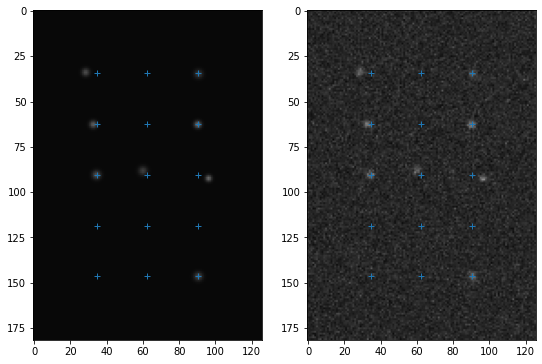

In [12]:
frame = 15

plt.figure(figsize=(9,13/2))
plt.subplot(121)
plt.imshow(locs[frame].data, cmap="gray", vmin=data.min(), vmax=data.max())
plt.plot(Y, X, "C0+")

plt.subplot(122)
plt.imshow(data[frame].data, cmap="gray", vmin=data.min(), vmax=data.max())
plt.plot(Y, X, "C0+")
plt.show()

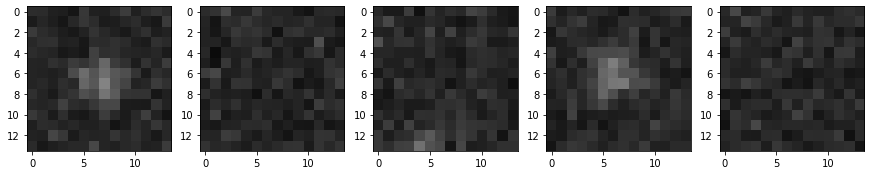

In [13]:
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(cosmos_data[0,i].data, vmin=data.min(), vmax=data.max(), cmap="gray")
plt.show()

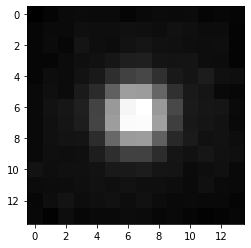

In [14]:
plt.imshow(cosmos_data.mean(dim=(0,1)), cmap="gray")
plt.show()

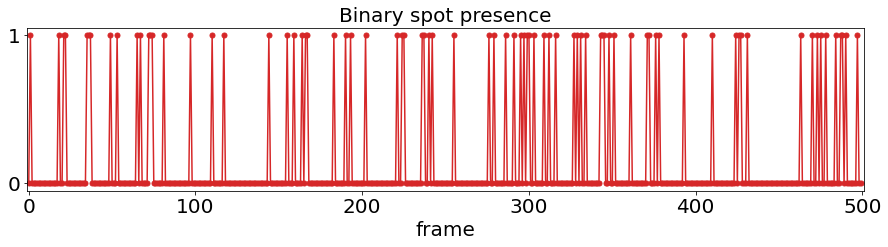

In [15]:
plt.figure(figsize=(15,3))
plt.plot(labels["z"][1], marker="o", ms=5, color="C3")
#plt.ylim(0,1)
plt.xlim(-1,501)
plt.xlabel(r"frame", fontsize=20)
#plt.ylabel(r"spot presence", fontsize=20)
plt.title(r"Binary spot presence", fontsize=20)
plt.gca().axes.get_yaxis().set_ticks(np.arange(2)*1)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Results

In [36]:
names = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]
# snr = [float(name) for name in names]

In [37]:
rv = dist.MultivariateNormal(
    torch.tensor([6.5, 6.5]),
    scale_tril=torch.eye(2) * torch.tensor([1.4])[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

In [38]:
# calculate signal-to-noise ratio
snr = []
for h in heights:
    spot = rv.log_prob(ij_pixel).exp() * float(h)
    signal = (spot * rv.log_prob(ij_pixel).exp()).sum()
    noise = (background * gain).sqrt()
    snr.append(float(signal / noise))

Tracker v1.1.3flat

In [82]:
params_last = {}
predictions = {}
labels = {}

names = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]

for name in names:
    params_last[name] = pd.read_csv(
        "/shared/centaur/data/height_data/h{}pi{}lamda{}/runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"
        .format(name, pi_z, lamda_j),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        "/shared/centaur/data/height_data/h{}pi{}lamda{}/runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/predictions.npy"
        .format(name, pi_z, lamda_j))
    labels[name] = np.load("/shared/centaur/data/height_data/h{}pi{}lamda{}/labels.npy"
                                .format(name, pi_z, lamda_j))

In [83]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
scores_v1p13["SNR"] = snr
scores_v1p13

,iter,-ELBO,gain,pi_1,lamda_1,MCC,Recall,Precision,FN,TP,TN,FP,SNR
0300,19900.0,14367738.0,7.049694,0.000943,0.000003,0.053758,0.003422,1.000000,1165.0,4.0,6331.0,0.0,0.375890
0500,19900.0,14385291.0,7.089531,0.033164,0.000130,0.346409,0.156544,0.915000,986.0,183.0,6314.0,17.0,0.626483
0750,27600.0,14409646.0,7.154151,0.130141,0.014876,0.785407,0.738238,0.899896,306.0,863.0,6235.0,96.0,0.939725
1000,19900.0,14422989.0,7.122874,0.170072,0.057632,0.913743,0.964927,0.891700,41.0,1128.0,6194.0,137.0,1.252967
1500,19900.0,14448320.0,7.122674,0.169053,0.100234,0.941651,0.993157,0.910588,8.0,1161.0,6217.0,114.0,1.879450
2000,21800.0,14463078.0,7.122825,0.173191,0.112174,0.949082,0.995723,0.920158,5.0,1164.0,6230.0,101.0,2.505933
3000,19900.0,14486173.0,7.184220,0.170759,0.126235,0.951575,0.998289,0.921801,2.0,1167.0,6232.0,99.0,3.758900


In [21]:
params_last = {}
predictions = {}
labels = {}

names = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]

for name in names:
    params_last[name] = pd.read_csv(
        "/shared/centaur/data/height_data/h{}pi{}lamda{}/runs/tracker/v1.1.3prox/S1/control/lr0.005/bs5/params_last.csv"
        .format(name, pi_z, lamda_j),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        "/shared/centaur/data/height_data/h{}pi{}lamda{}/runs/tracker/v1.1.3prox/S1/control/lr0.005/bs5/predictions.npy"
        .format(name, pi_z, lamda_j))
    labels[name] = np.load("/shared/centaur/data/height_data/h{}pi{}lamda{}/labels.npy"
                                .format(name, pi_z, lamda_j))

In [23]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
#scores_v1p13["SNR"] = snr
scores_v1p13

,iter,-ELBO,proximity_0,gain,pi_1,lamda_1,MCC,Recall,Precision,FN,TP,TN,FP
0300,19900.0,14368863.0,207.268692,7.038551,0.000811,0.000003,0.053758,0.003422,1.000000,1165.0,4.0,6331.0,0.0
0500,19900.0,14385854.0,508.292938,7.097323,0.033103,0.000242,0.358278,0.165098,0.923445,976.0,193.0,6315.0,16.0
0750,19900.0,14400730.0,469.862457,7.121178,0.134076,0.018434,0.801731,0.757057,0.908624,284.0,885.0,6242.0,89.0
1000,19900.0,14425721.0,521.454834,7.131936,0.168000,0.064852,0.924098,0.965783,0.907556,40.0,1129.0,6216.0,115.0
1500,19900.0,14442172.0,776.682007,7.114840,0.167034,0.110310,0.943645,0.974337,0.931316,30.0,1139.0,6247.0,84.0
2000,9900.0,14455481.0,732.574097,7.110734,0.156766,0.118632,0.947810,0.965783,0.946354,40.0,1129.0,6267.0,64.0
3000,19900.0,14466910.0,1133.276367,7.070730,0.161538,0.141415,0.963446,0.966638,0.971625,39.0,1130.0,6298.0,33.0


In [64]:
sp_results = {}

for name in names:
    sp_results[name] = loadmat("/shared/centaur/data//{}_data/h{}.mat".format(sim, name))

In [65]:
scores_sp = pd.DataFrame(data={"spMCC": [matthews_corrcoef(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
                   "spRecall": [recall_score(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
                   "spPrecision": [precision_score(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
                    },
             index=names)
scores_sp

,spMCC,spRecall,spPrecision
0300,0.347883,0.166809,0.878378
0500,0.570095,0.420873,0.888087
0750,0.759349,0.685201,0.912301
1000,0.872431,0.858854,0.925346
1500,0.941323,0.974337,0.927524
2000,0.950915,0.984602,0.933496
3000,0.951547,0.980325,0.938575


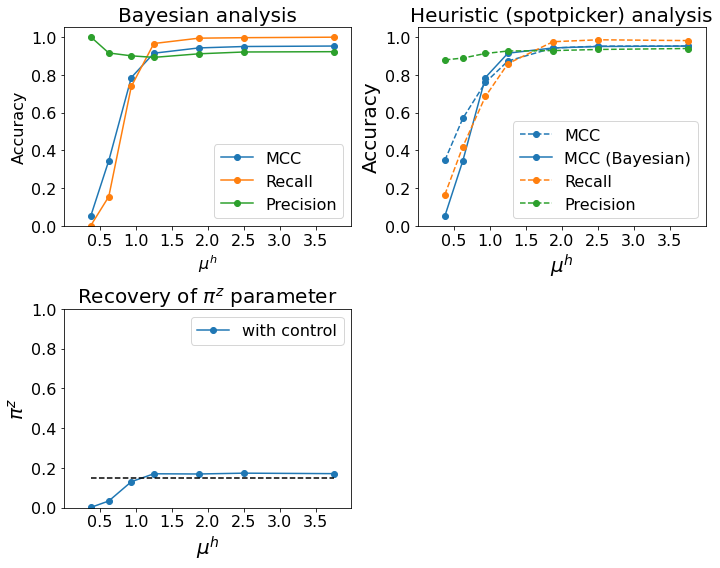

In [70]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")
#plt.plot(snr, fnr, "o-", label="FNR")
#plt.plot(snr, fpr, "o-", label="FPR")
plt.ylim(0,1.05)
plt.xlim(0,4)
plt.xlabel(r"$\mu^h$", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,8)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
#plt.plot(snr, fnr, "o-", label="FNR")
#plt.plot(snr, fpr, "o-", label="FPR")
plt.ylim(0,1.05)
plt.xlim(0,4)
plt.xlabel(r"$\mu^h$", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,8)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.subplot(223)
plt.plot(snr, scores_v1p13["pi_1"], "o-", label="with control")
plt.plot([snr[0], snr[-1]], [float(pi_z)/100, float(pi_z)/100], "--", c="k")
plt.ylim(0,1)
plt.xlim(0,4)
plt.xlabel(r"$\mu^h$", fontsize=20)
plt.ylabel(r"$\pi^z$", fontsize=20)
plt.title(r"Recovery of $\pi^z$ parameter", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,8)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

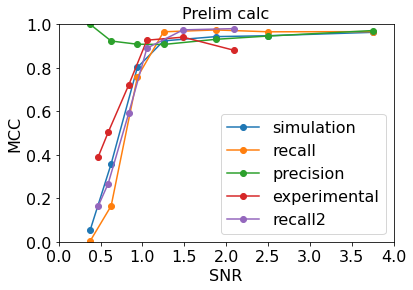

In [41]:
snr2 = np.array([0.63, 0.79, 1.12, 1.41, 1.99, 2.81]) * 2.1 / 2.81
snr3 = np.array([0.63, 0.79, 1.12, 1.41, 1.99, 2.81])
mcc2 = np.array([0.38985816, 0.50288344, 0.721728  , 0.9271966 , 0.94118549,
       0.88025585])
recall2 = np.array([0.1633888 , 0.26680527, 0.59170013, 0.89061763, 0.97470238,
       0.98042169])

plt.plot(snr, scores_v1p13["MCC"], "o-", label="simulation")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="precision")
plt.plot(snr2, mcc2, "o-", label="experimental")
plt.plot(snr2, recall2, "o-", label="recall2")
plt.title("Prelim calc", fontsize=16)
plt.xlabel("SNR", fontsize=16)
plt.ylabel("MCC", fontsize=16)
plt.xlim(0, 4)
plt.ylim(0, 1)

plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

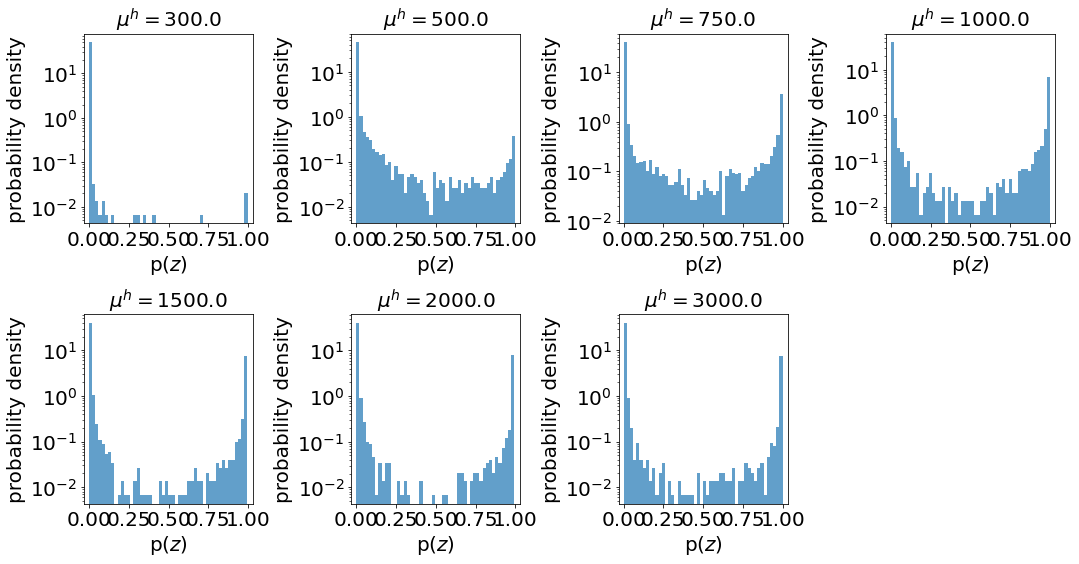

In [26]:
plt.figure(figsize=(15,15))
for i, h in enumerate(heights):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[h]["z_prob"].ravel(), bins=50, density=True, alpha=0.7)
    plt.xlim(-0.03, 1.03)
    plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  import sys


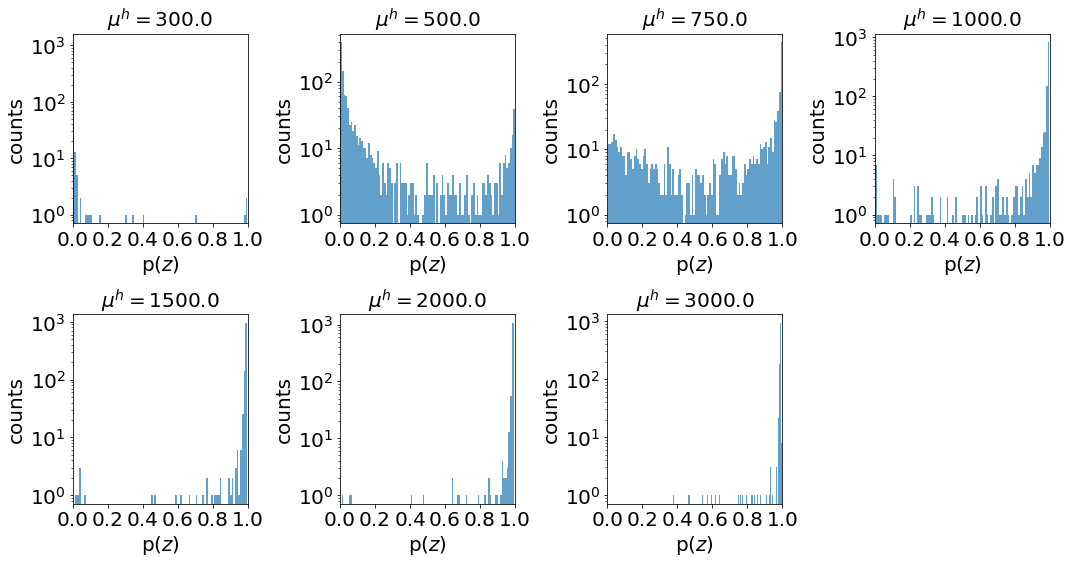

In [27]:
plt.figure(figsize=(15,15))
for i, h in enumerate(heights):
    plt.subplot(4, 4, i+1)
    mask = true_labels[h]["z"]
    plt.hist(predictions[h]["z_prob"][mask], bins=100, alpha=0.7)
    plt.xlim(0, 1)
    plt.yscale('log', nonposy='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"counts", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

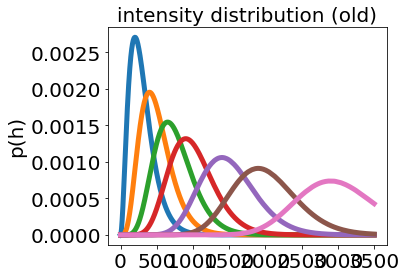

In [28]:
x = torch.arange(0,3500.,0.1)

plt.figure(figsize=(5,4))
for h in heights:
    d = dist.Gamma(float(h) * 0.01, 0.01)
    plt.plot(x, torch.exp(d.log_prob(x)).cpu(), lw=5)
#plt.plot(x, torch.exp(d2.log_prob(x)).cpu(), color="C1", lw=5)

#plt.gca().axes.get_xaxis().set_ticks([100])
#plt.gca().axes.get_yaxis().set_ticks([])
#plt.xticks(size=30)
plt.title("intensity distribution (old)", fontsize=20)
plt.ylabel("p(h)", fontsize=20)
#plt.ylim(0, 0.003)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [27]:
from cosmos.models import GaussianSpot

In [52]:
spot = rv.log_prob(ij_pixel).exp() * 300

In [53]:
# locs = spot
avg = (spot * rv.log_prob(ij_pixel).exp()).sum()
avg

tensor(12.1802)

In [54]:
std = (background * gain).sqrt()

In [56]:
heights

['0300', '0500', '0750', '1000', '1500', '2000', '3000']

In [58]:
snr = []
for h in heights:
    spot = rv.log_prob(ij_pixel).exp() * float(h)
    signal = (spot * rv.log_prob(ij_pixel).exp()).sum()
    noise = (background * gain).sqrt()
    snr.append(signal / noise)

In [59]:
snr

[tensor([0.3759]),
 tensor([0.6265]),
 tensor([0.9397]),
 tensor([1.2530]),
 tensor([1.8794]),
 tensor([2.5059]),
 tensor([3.7589])]

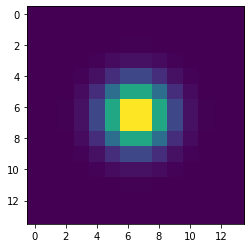

In [37]:
plt.imshow(spot)

In [92]:
import pyro.distributions.transforms as T
base_dist = dist.HalfNormal(torch.ones(1))
spline_transform = T.Spline(1, count_bins=12, order="linear")
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

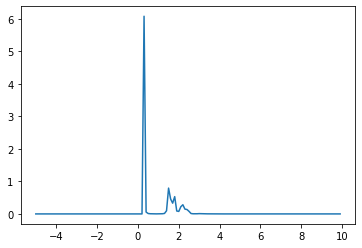

In [93]:
x = torch.arange(-5,10,0.1)[:, None]
plt.plot(x, flow_dist.log_prob(x).exp().data)
plt.show()

In [88]:
flow_dist.transforms[0]._params()

(tensor([[0.0756, 0.7284, 0.1960]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4799, 0.1853, 0.3348]], grad_fn=<SoftmaxBackward>),
 tensor([[0.9436, 1.1852]], grad_fn=<SoftplusBackward>),
 tensor([[0.6113, 0.6540, 0.5948]], grad_fn=<SigmoidBackward>))